### RFM Study Background: 
#### RFM (Recency, Frequency, Monetary) analysis is commonly used for customer segmentation.
#### This time, I will use a transactional dataset to perform a RFM Analysis.

### Step 1: Import Library and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df=pd.read_csv('TransactionData.csv')

### Step 2: Exploratory Data Analysis

In [3]:
df.head(3)  # There are 5 columns: MembershipNo, Card No, Transaction Date and Point

,Membership No,Card No,Transaction Date,Point
0,35456,334,19/5/2018,142
1,35456,334,7/12/2018,219
2,35456,334,19/5/2018,219


In [4]:
df.info() # There is no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209641 entries, 0 to 209640
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Membership No     209641 non-null  int64 
 1   Card No           209641 non-null  int64 
 2   Transaction Date  209641 non-null  object
 3   Point             209641 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ MB


### Step 2a: Data Transformation:

In [5]:
## 1) Change Membership No and Card No as String
#df[['Membership No','Card No']]=df[['Membership No','Card No']].astype('category')
### Do not convert to Category due to too long execution time

## 2) Change Transaction Date to Date Value
from datetime import datetime
df['Date_format']=df['Transaction Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))

In [6]:
print('No. of Distinct Customer')
print('--------------------------------------------')
print(df['Membership No'].nunique())
print('\n')
print('No. of Card owned by each customer Summary')
print('--------------------------------------------')
print(df.groupby('Membership No').agg({'Card No':'nunique'}).groupby('Card No').agg(No_of_Customer=('Card No','count')).T)
print('\n')
print('Point Distribution (Total)')
print('--------------------------------------------')
print(df.groupby('Membership No').agg({'Point':'sum'}).describe())
print('\n')
print('Point Distribution (Average)')
print('--------------------------------------------')
print(df.groupby('Membership No').agg({'Point':'mean'}).describe())
print('\n')
print('Point Distribution (Total)')
print('--------------------------------------------')

No. of Distinct Customer
--------------------------------------------
17175


No. of Card owned by each customer Summary
--------------------------------------------
Card No            1     2     3    4   5   6   7   8   10  11  15  16
No_of_Customer  11160  4301  1438  218  33  12   4   2   4   1   1   1


Point Distribution (Total)
--------------------------------------------
              Point
count  17175.000000
mean    3258.334440
std     3090.526997
min      101.000000
25%     1060.500000
50%     2411.000000
75%     4489.500000
max    57130.000000


Point Distribution (Average)
--------------------------------------------
              Point
count  17175.000000
mean     263.978777
std       47.005284
min      101.000000
25%      235.571429
50%      253.937500
75%      283.351909
max      992.000000


Point Distribution (Total)
--------------------------------------------


### Step 3: Data Aggregation

In [7]:
## Calculate No. of Day between transaction date and 2021/01/01
import datetime
curr_date = datetime.datetime(2021, 1,1)

## Calculate no. of day between latest transaction date and 2021/01/01
df['No_of_Day']=df['Date_format'].apply(lambda x: curr_date-x)

In [8]:
print(' Earliest Transaction Date: '+ str(df['Date_format'].min()) +'\n Latest Transaction Date: '+ str(df['Date_format'].max()))

 Earliest Transaction Date: 2018-01-01 00:00:00
 Latest Transaction Date: 2020-12-25 00:00:00


In [10]:
df.head(5)

,Membership No,Card No,Transaction Date,Point,Date_format,No_of_Day
0,35456,334,19/5/2018,142,2018-05-19,958 days
1,35456,334,7/12/2018,219,2018-12-07,756 days
2,35456,334,19/5/2018,219,2018-05-19,958 days
3,16859,377,30/6/2018,267,2018-06-30,916 days
4,16859,377,2/4/2018,267,2018-04-02,1005 days


In [11]:
### Monetary Handling: Combine Multiple Transaction to one in the same Transaction day:
M1=df.groupby(['Membership No','Date_format']).agg({'Point':'sum'})
M1=M1.reset_index()

In [12]:
## Validation: To see if combination is correct or not:
M1[M1['Membership No']==35456]

,Membership No,Date_format,Point
22743,35456,2018-05-19,361
22744,35456,2018-06-04,464
22745,35456,2018-12-07,219
22746,35456,2019-11-07,489


In [13]:
### Monetary and Frequency:
M2=M1.groupby('Membership No').agg({'Date_format':'count','Point':'sum'})
M2['Monetary_Average']=M2['Point']/M2['Date_format']
M2.columns=['Frequency','Monetary','Monetary_Average']
M2.head()

,Frequency,Monetary,Monetary_Average
Membership No,,,
10011,5,3322,664.400000
10018,3,2024,674.666667
10019,2,1356,678.000000
10032,5,2392,478.400000
10038,6,3756,626.000000


In [14]:
### Recency:
R1=df.groupby('Membership No').agg({'No_of_Day':'min'})

In [15]:
RFM=R1.merge(M2,on='Membership No',how='left')
RFM=RFM.drop('Monetary', axis=1)
RFM['No_of_Day']=RFM['No_of_Day'].astype('timedelta64[D]')
RFM.columns=['R','F','M']

In [16]:
RFM.describe()

,R,F,M
count,17175.000000,17175.000000,17175.000000
mean,356.379389,5.128734,626.180690
std,298.566422,4.669403,242.879428
min,7.000000,1.000000,101.000000
25%,105.000000,2.000000,483.480769
50%,270.000000,4.000000,594.500000
75%,531.000000,7.000000,736.708333
max,1096.000000,93.000000,3078.000000


### Step 4: Calucate RFM Score and do Segmentation

In [99]:
quantiles = RFM.quantile(q=[0.25,0.5,0.75])
print(quantiles)

RFM.loc[RFM.R<105,'R_Score']=4
RFM.loc[(RFM.R>=105) & (RFM.R<270),'R_Score']=3
RFM.loc[(RFM.R>=270) & (RFM.R<531),'R_Score']=2
RFM.loc[RFM.R>=531,'R_Score']=1

RFM.loc[RFM.F<2,'F_Score']=1
RFM.loc[(RFM.F>=2) & (RFM.F<4),'F_Score']=2
RFM.loc[(RFM.F>=4) & (RFM.F<7),'F_Score']=3
RFM.loc[RFM.F>=7,'F_Score']=4

RFM.loc[RFM.M<483.480769,'M_Score']=1
RFM.loc[(RFM.M>=483.480769) & (RFM.M<594.500000),'M_Score']=2
RFM.loc[(RFM.M>=594.500000) & (RFM.M<736.708333),'M_Score']=3
RFM.loc[RFM.M>=736.708333,'M_Score']=4

RFM['R_Score']=RFM['R_Score'].astype(int)
RFM['F_Score']=RFM['F_Score'].astype(int)
RFM['M_Score']=RFM['M_Score'].astype(int)

RFM['RFM_Group']=RFM['R_Score']*100+RFM['F_Score']*10+RFM['M_Score']

#print(RFM.head(3))

          R    F           M  R_Score  F_Score  M_Score  RFM_Group  Color
0.25  105.0  2.0  483.480769      1.0      2.0      1.5      144.0    3.0
0.50  270.0  4.0  594.500000      2.0      3.0      3.0      244.0    5.0
0.75  531.0  7.0  736.708333      3.0      4.0      3.5      344.0    8.0


In [87]:
#Customer Segmentation 
RFM['Segmentation']=''
RFM.loc[RFM.RFM_Group==444,'Segmentation']='0 The Best Customer'
RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score>=3) & (RFM.F_Score>=3)& (RFM.M_Score>=3) ,'Segmentation']='1 Loyal Customer'
RFM.loc[(RFM.Segmentation=='') & ((RFM.RFM_Group==414) | (RFM.RFM_Group==413)) ,'Segmentation']='2 New Customer with High Spending'

RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score<=2) & (RFM.F_Score>=3) & (RFM.M_Score>=3) ,'Segmentation']='3 Potential Customer who is going to be lapsed'
RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score>=3) & (RFM.F_Score<=2) & (RFM.M_Score>=3) ,'Segmentation']='4 Potential Customer who only visit for a few time'
RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score>=3) & (RFM.F_Score>=3) & (RFM.M_Score<=2) ,'Segmentation']='5 Potential Customer with low spending'

RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score<=2) & (RFM.F_Score<=2) & (RFM.M_Score>=3) ,'Segmentation']='6 High Spending Customer need to pay more attention'
RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score>=3) & (RFM.F_Score<=2) & (RFM.M_Score<=2) ,'Segmentation']='7 New Customer with Low Spending'
RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score<=2) & (RFM.F_Score>=3) & (RFM.M_Score<=2) ,'Segmentation']='8 Low Spending Customer who visited frequently in the past'

RFM.loc[(RFM.Segmentation=='') & (RFM.R_Score<=2) & (RFM.F_Score<=2) & (RFM.M_Score<=2) ,'Segmentation']='9 Low Spending Customer who is going to be lapsed.'


RFM['Color']=RFM['Segmentation'].astype(str).str[0].astype(int)

### Step 5: Display Customer Segmentation Result

In [88]:
RFM.groupby('Segmentation').agg({'Segmentation':'count'})

,Segmentation
Segmentation,
0 The Best Customer,506
1 Loyal Customer,3534
2 New Customer with High Spending,55
3 Potential Customer who is going to be lapsed,1337
4 Potential Customer who only visit for a few time,804
5 Potential Customer with low spending,2680
6 High Spending Customer need to pay more attention,2357
7 New Customer with Low Spending,984
8 Low Spending Customer who visited frequently in the past,1270


### Reference

#### Vistualization before data cleaning (Tune Outlier)

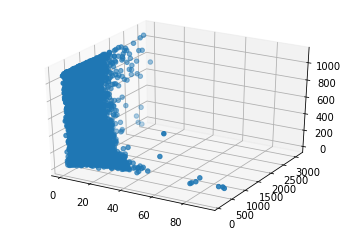

In [89]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = RFM['R']
xdata = RFM['F']
ydata = RFM['M']

ax.scatter3D(xdata, ydata, zdata);

Text(0.5, 1.0, 'Days since last purchase')

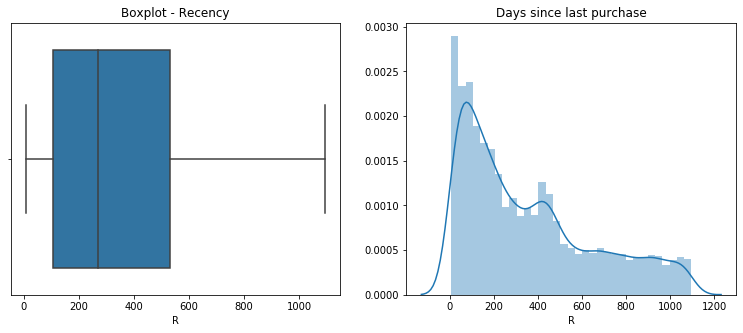

In [90]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.boxplot(x=RFM["R"],ax=ax1)
ax1.set_title("Boxplot - Recency")
sns.distplot(RFM['R'],ax=ax2)
ax2.set_title("Days since last purchase")

#### In our Segmentation, we split Recency to 4 groups:
#### 1) Recency < 105 days
#### 2) Recency >= 105 days and <270 days
#### 3) Recency >= 270 days and <531 days
#### 4) Recency >=531 days

Text(0.5, 1.0, 'No. of Transaction')

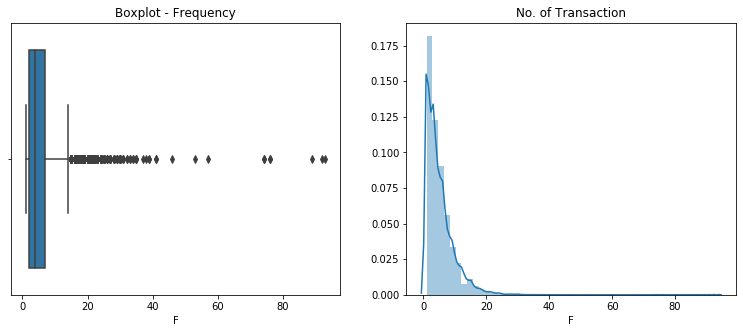

In [91]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.boxplot(x=RFM["F"],ax=ax1)
ax1.set_title("Boxplot - Frequency")
sns.distplot(RFM['F'],ax=ax2)
ax2.set_title("No. of Transaction")

Text(0.5, 1.0, 'Avg. of Point gained in each transaction')

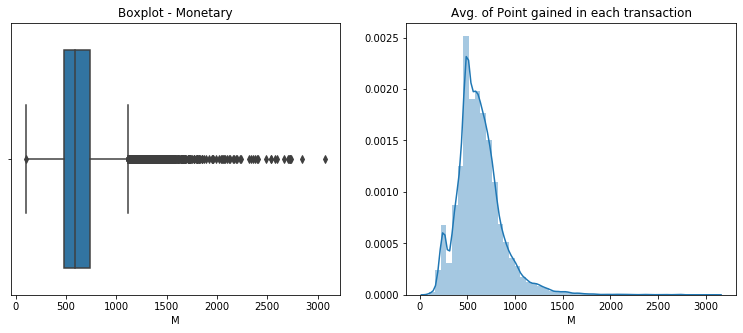

In [92]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.boxplot(x=RFM["M"],ax=ax1)
ax1.set_title("Boxplot - Monetary")
sns.distplot(RFM['M'],ax=ax2)
ax2.set_title("Avg. of Point gained in each transaction")

### Ignore outlier and visualize Frequency and Monetary again can get better visualization result

In [93]:
### Find Frequency's Outlier
FQ1 = np.percentile(RFM.loc[:,'F'], 25, interpolation = 'midpoint') # The lower quartile Q1 is calculated.
FQ3 = np.percentile(RFM.loc[:,'F'], 75, interpolation = 'midpoint') # The upper quartile Q3 is calculated.
FIQR = FQ3 - FQ1 # The Interquartile range is calculated.
print(FQ1- 1.5*FIQR,FQ3 + 1.5*FIQR)

### Find Monetary's Outlier
MQ1 = np.percentile(RFM.loc[:,'M'], 25, interpolation = 'midpoint') # The lower quartile Q1 is calculated.
MQ3 = np.percentile(RFM.loc[:,'M'], 75, interpolation = 'midpoint') # The upper quartile Q3 is calculated.
MIQR = MQ3 - MQ1 # The Interquartile range is calculated.
print(MQ1- 1.5*MIQR,MQ3 + 1.5*MIQR)


-5.5 14.5
103.63942307692315 1116.5496794871792


In [94]:
### Data Cleaning for Outlier:
RFM_DC=RFM.copy()
RFM_DC['F']=RFM_DC['F'].apply(lambda x:FQ1- 1.5*FIQR if x<-FQ1- 1.5*FIQR else x)
RFM_DC['F']=RFM_DC['F'].apply(lambda x:FQ3 + 1.5*FIQR if x>FQ3 + 1.5*FIQR else x)
RFM_DC['M']=RFM_DC['M'].apply(lambda x:MQ1- 1.5*MIQR if x<MQ1- 1.5*MIQR else x)
RFM_DC['M']=RFM_DC['M'].apply(lambda x:MQ3 + 1.5*MIQR if x>MQ3 + 1.5*MIQR else x)
RFM_DC.head(3)

,R,F,M,R_Score,F_Score,M_Score,RFM_Group,Segmentation,Color
Membership No,,,,,,,,,
10011,936.0,5.0,664.400000,1,3,3,133,3 Potential Customer who is going to be lapsed,3
10018,684.0,3.0,674.666667,1,2,3,123,6 High Spending Customer need to pay more atte...,6
10019,938.0,2.0,678.000000,1,2,3,123,6 High Spending Customer need to pay more atte...,6


Text(0.5, 1.0, 'No. of Transaction')

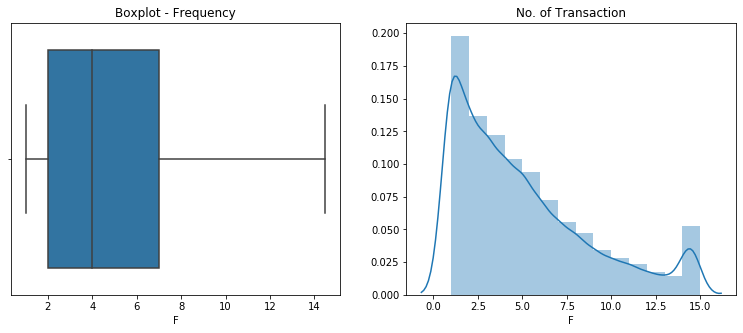

In [95]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.boxplot(x=RFM_DC["F"],ax=ax1)
ax1.set_title("Boxplot - Frequency")
sns.distplot(RFM_DC['F'],bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],ax=ax2)
ax2.set_title("No. of Transaction")

#### In our Segmentation, we split Frequency to 4 groups:
#### 1) Frequency = 1 time
#### 2) Frequency = 2 or 3 times
#### 3) Frequency = 4 or 5 or 6 times
#### 4) Frequency >=7 times

Text(0.5, 1.0, 'Avg. of Point gained in each transaction')

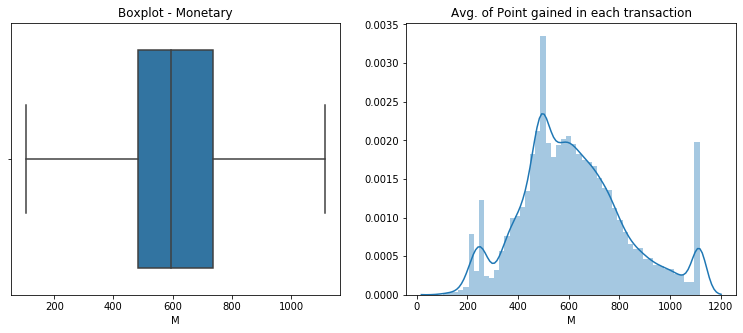

In [96]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.boxplot(x=RFM_DC["M"],ax=ax1)
ax1.set_title("Boxplot - Monetary")
sns.distplot(RFM_DC['M'],ax=ax2)
ax2.set_title("Avg. of Point gained in each transaction")

#### In our Segmentation, we split Monetary(Point Gained) to 4 groups:
#### 1) Point <483.480769
#### 2) Point >=483.480769 and <594.500000
#### 3) Point >=594.500000 and <736.708333
#### 4) Point >=736.708333

### Here, we can have a look of our Customer Segmentation

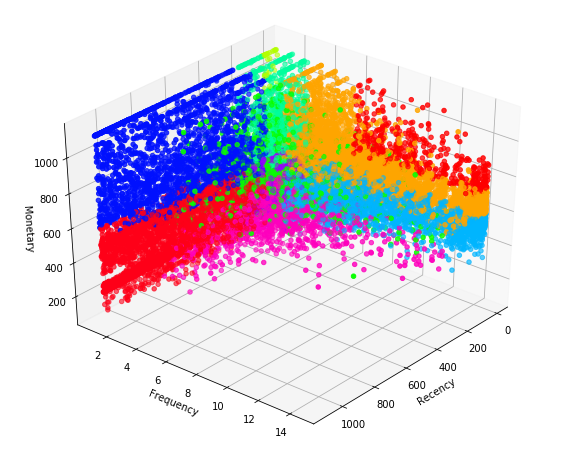

In [97]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_DC['R'], RFM_DC['F'], RFM_DC['M'], c=RFM_DC['Color'],cmap='hsv',label='Color')


ax.set_xlabel('Recency', fontsize=10, rotation=150)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_zlabel('Monetary', fontsize=10, rotation=60)

ax.view_init(35, 40)

plt.show()

### Recap:

In [98]:
RFM.groupby('Segmentation').agg(No_of_customer=('Segmentation','count'))

,No_of_customer
Segmentation,
0 The Best Customer,506
1 Loyal Customer,3534
2 New Customer with High Spending,55
3 Potential Customer who is going to be lapsed,1337
4 Potential Customer who only visit for a few time,804
5 Potential Customer with low spending,2680
6 High Spending Customer need to pay more attention,2357
7 New Customer with Low Spending,984
8 Low Spending Customer who visited frequently in the past,1270


### Segmentation Defination:
#### 0 The Best Customer: Customer visited within past 105 days, visited >= 7 times, and gained >= 736.708333 points
#### 1 Loyal Customer: Customer visited within past 270 days and visited >= 4 times, and gained >= 594.5 points
#### 2 New Customer with High Spending: Customer visited only 1 time within past 105 days and gained >=594.5 points
#### 3 Potential Customer who is going to be lapsed: Customer visited >=4 times and gained >=594.5 points BUT NOT RETURNED within 270 days
#### 4 Potential Customer who only visit for a few time: Customer visited within past 270 days and gained >=594.5 points BUT VISIT LESS THAN 4 times
#### 5 Potential Customer with low spending: Customer visited within past 270 days and visited >=4 times BUT GAINED LESS THAN 594.5 points
#### 6 High Spending Customer need to pay more attention: Customer gained >= 594.5 points BUT VISITED LESS THAN 4 times and NOT RETURNED within 270 days
#### 7 New Customer with Low Spending: Customer visited within past 270 days BUT VISIT LESS THAN 4 times and GAINED LESS THAN 594.5 points
#### 8 Low Spending Customer who visited frequently in the past: Customers visited >= 4 times BUT GAINED LESS THAN 594.5 points
#### 9 Low Spending Customer who is going to be lapsed: Customer DID NOT RETURNED within 270 day, VISIT LESS THAN 4 times and GAINED LESS THAN 594.5 points

### Further Study:
#### Next Time I will perform a k-means study and compare the result with the above RFM results